In [1]:
import os
import numpy as np
import tifffile
import pickle

def compute_frame_metrics(data_dir="raw_data",
                         cubes=range(1,5),
                         conditions=range(1,13),
                         lines=range(1,6),
                         max_frames=None):
    """
    Loop over every cube, condition, and line, and for each video:
      - Read all (or up to `max_frames`) frames from the TIF.
      - Compute multiple metrics for each frame:
        * Sum of pixel intensities (float)
        * Number of saturated pixels (using uint16 max value of 65535)
        * Maximum pixel value in the frame
      - Store the resulting metrics in a nested dictionary:
        results[cube][condition][line] = {
            'intensities': 1D array of sums,
            'saturated_pixels': 1D array of counts,
            'max_values': 1D array of maximums
        }
    
    Parameters
    ----------
    data_dir : str
        Base directory where 'cubeX' folders reside.
    cubes : iterable
        Which cubes to process. Example: range(1,5).
    conditions : iterable
        Which conditions to process. Example: range(1,13).
    lines : iterable
        Which lines to process. Example: range(1,6).
    max_frames : int or None
        If not None, limits the number of frames read per video (for testing).
        
    Returns
    -------
    results : dict
        Nested dictionary with structure 
        results[cube][condition][line] = dict of metric arrays
    """
    results = {}
    # uint16 max value for saturation detection
    SATURATION_THRESHOLD = 4095
    
    for cube_number in cubes:
        results[cube_number] = {}
        cube_folder = f"cube{cube_number}"
        
        for condition_number in conditions:
            results[cube_number][condition_number] = {}
            # The subfolder name pattern
            condition_subfolder = f"cube{cube_number}_C001H001S00{condition_number:02d}"
            
            for line_number in lines:
                # The TIF filename pattern
                tif_filename = f"cube{cube_number}_C001H001S00{condition_number:02d}-{(line_number-1):02d}.tif"
                file_path = os.path.join(data_dir, cube_folder, condition_subfolder, tif_filename)
                
                # Safety check if file doesn't exist
                if not os.path.isfile(file_path):
                    print(f"Warning: File not found {file_path}. Skipping.")
                    continue
                
                print(f"Processing: Cube={cube_number}, Condition={condition_number}, Line={line_number}")
                
                # Initialize lists for each metric
                intensities = []
                saturated_counts = []
                max_values = []
                
                with tifffile.TiffFile(file_path) as tif:
                    n_frames = len(tif.pages)
                    frames_to_read = n_frames if max_frames is None else min(max_frames, n_frames)
                    
                    for i in range(frames_to_read):
                        frame = tif.pages[i].asarray()  # uint16
                        
                        # Compute metrics
                        intensities.append(float(np.sum(frame)))
                        saturated_counts.append(int(np.sum(frame >= SATURATION_THRESHOLD)))
                        max_values.append(int(np.max(frame)))
                
                # Store all metrics in the nested dictionary
                results[cube_number][condition_number][line_number] = {
                    'intensities': np.array(intensities, dtype=float),
                    'saturated_pixels': np.array(saturated_counts, dtype=int),
                    'max_values': np.array(max_values, dtype=int)
                }
    
    return results

def save_frame_metrics(results, filename="frame_metrics.pkl"):
    """
    Save the nested dictionary of metrics to disk with pickle.
    """
    with open(filename, "wb") as f:
        pickle.dump(results, f)
    print(f"Saved frame metrics to {filename}")

In [2]:
results = compute_frame_metrics(data_dir="raw_data")


Processing: Cube=1, Condition=1, Line=1
Processing: Cube=1, Condition=1, Line=2
Processing: Cube=1, Condition=1, Line=3
Processing: Cube=1, Condition=1, Line=4
Processing: Cube=1, Condition=1, Line=5
Processing: Cube=1, Condition=2, Line=1
Processing: Cube=1, Condition=2, Line=2
Processing: Cube=1, Condition=2, Line=3
Processing: Cube=1, Condition=2, Line=4
Processing: Cube=1, Condition=2, Line=5
Processing: Cube=1, Condition=3, Line=1
Processing: Cube=1, Condition=3, Line=2
Processing: Cube=1, Condition=3, Line=3
Processing: Cube=1, Condition=3, Line=4
Processing: Cube=1, Condition=3, Line=5
Processing: Cube=1, Condition=4, Line=1
Processing: Cube=1, Condition=4, Line=2
Processing: Cube=1, Condition=4, Line=3
Processing: Cube=1, Condition=4, Line=4
Processing: Cube=1, Condition=4, Line=5
Processing: Cube=1, Condition=5, Line=1
Processing: Cube=1, Condition=5, Line=2
Processing: Cube=1, Condition=5, Line=3
Processing: Cube=1, Condition=5, Line=4
Processing: Cube=1, Condition=5, Line=5


Processing: Cube=4, Condition=5, Line=5
Processing: Cube=4, Condition=6, Line=1
Processing: Cube=4, Condition=6, Line=2
Processing: Cube=4, Condition=6, Line=3
Processing: Cube=4, Condition=6, Line=4
Processing: Cube=4, Condition=6, Line=5
Processing: Cube=4, Condition=7, Line=1
Processing: Cube=4, Condition=7, Line=2
Processing: Cube=4, Condition=7, Line=3
Processing: Cube=4, Condition=7, Line=4
Processing: Cube=4, Condition=7, Line=5
Processing: Cube=4, Condition=8, Line=1
Processing: Cube=4, Condition=8, Line=2
Processing: Cube=4, Condition=8, Line=3
Processing: Cube=4, Condition=8, Line=4
Processing: Cube=4, Condition=8, Line=5
Processing: Cube=4, Condition=9, Line=1
Processing: Cube=4, Condition=9, Line=2
Processing: Cube=4, Condition=9, Line=3
Processing: Cube=4, Condition=9, Line=4
Processing: Cube=4, Condition=9, Line=5
Processing: Cube=4, Condition=10, Line=1
Processing: Cube=4, Condition=10, Line=2
Processing: Cube=4, Condition=10, Line=3
Processing: Cube=4, Condition=10, Lin

In [3]:
save_frame_metrics(results, "frame_metrics.pkl")

Saved frame metrics to frame_metrics.pkl


In [4]:
import pickle
import matplotlib.pyplot as plt

def load_frame_metrics(filename="frame_metrics.pkl"):
    """
    Load the nested dictionary containing multiple metrics per video from a pickle file.
    Structure: {cube -> {condition -> {line -> {metric -> 1D array}}}}
    """
    with open(filename, "rb") as f:
        data = pickle.load(f)
    print(f"Loaded frame metrics from {filename}")
    return data

def plot_metric(results, cube, condition, line, metric_name):
    """
    Plot the evolution of a specific metric over time.
    
    Parameters
    ----------
    results : dict
        The nested dictionary containing the metrics
    cube : int
        Cube number
    condition : int
        Condition number
    line : int
        Line number
    metric_name : str
        Name of the metric to plot ('intensities', 'saturated_pixels', or 'max_values')
    """
    signal = results[cube][condition][line][metric_name]
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    plt.figure(figsize=(6,4))
    plt.plot(signal, label=f'Cube={cube}, Condition={condition}, Line={line}')
    plt.xlabel('Frame index')
    plt.ylabel(ylabel_map[metric_name])
    plt.title(f'Evolution of {metric_name.replace("_", " ")} over time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_metrics(results, cube, condition, line):
    """
    Create a figure with subplots showing all metrics for a specific video.
    
    Parameters
    ----------
    results : dict
        The nested dictionary containing the metrics
    cube : int
        Cube number
    condition : int
        Condition number
    line : int
        Line number
    """
    metrics = ['intensities', 'saturated_pixels', 'max_values']
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10))
    fig.suptitle(f'Metrics Evolution: Cube={cube}, Condition={condition}, Line={line}')
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    for ax, metric in zip(axes, metrics):
        signal = results[cube][condition][line][metric]
        ax.plot(signal)
        ax.set_xlabel('Frame index')
        ax.set_ylabel(ylabel_map[metric])
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_metric_comparison(results, cube, condition, metrics_to_compare=None):
    """
    Plot the same metric for all lines in a given condition, allowing for comparison.
    
    Parameters
    ----------
    results : dict
        The nested dictionary containing the metrics
    cube : int
        Cube number
    condition : int
        Condition number
    metrics_to_compare : list of str, optional
        List of metrics to compare. If None, plots all metrics.
    """
    if metrics_to_compare is None:
        metrics_to_compare = ['intensities', 'saturated_pixels', 'max_values']
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    n_metrics = len(metrics_to_compare)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 4*n_metrics))
    if n_metrics == 1:
        axes = [axes]
    
    fig.suptitle(f'Metrics Comparison: Cube={cube}, Condition={condition}')
    
    for ax, metric in zip(axes, metrics_to_compare):
        for line in results[cube][condition].keys():
            signal = results[cube][condition][line][metric]
            ax.plot(signal, label=f'Line {line}')
        
        ax.set_xlabel('Frame index')
        ax.set_ylabel(ylabel_map[metric])
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Load the data
results = load_frame_metrics("frame_metrics.pkl")


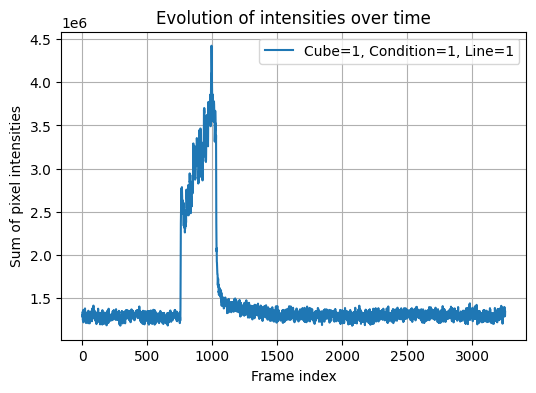

In [5]:
# Plot a single metric
plot_metric(results, cube=1, condition=1, line=1, metric_name='intensities')



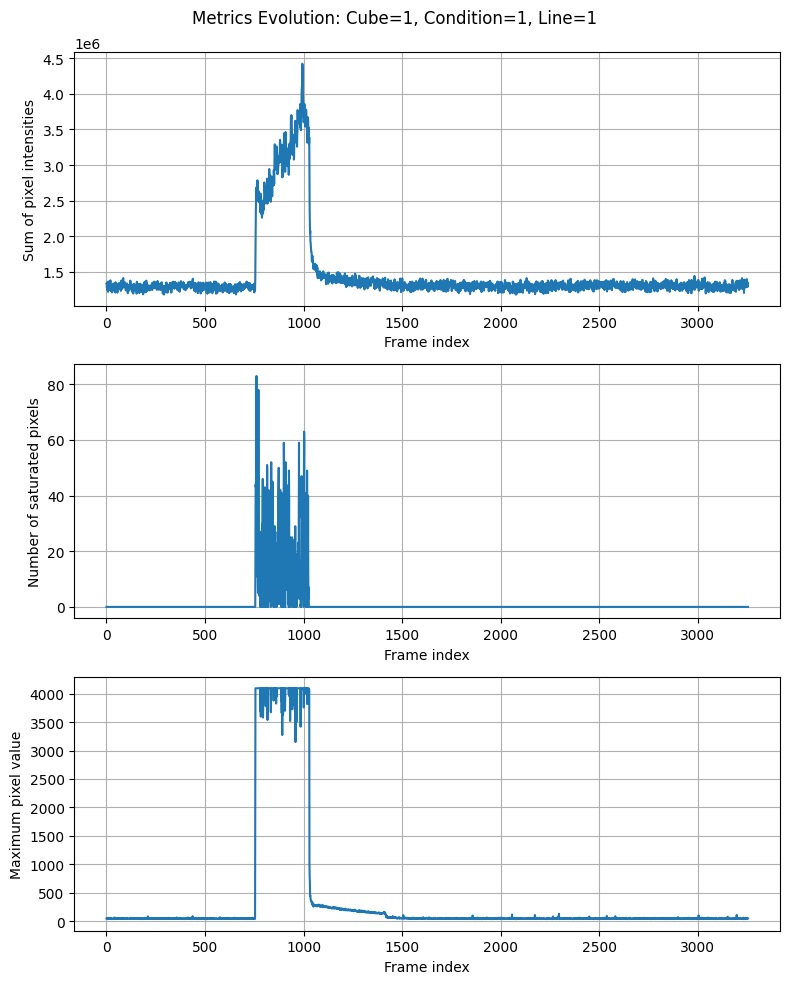

In [6]:
# Plot all metrics for a specific video
plot_all_metrics(results, cube=1, condition=1, line=1)



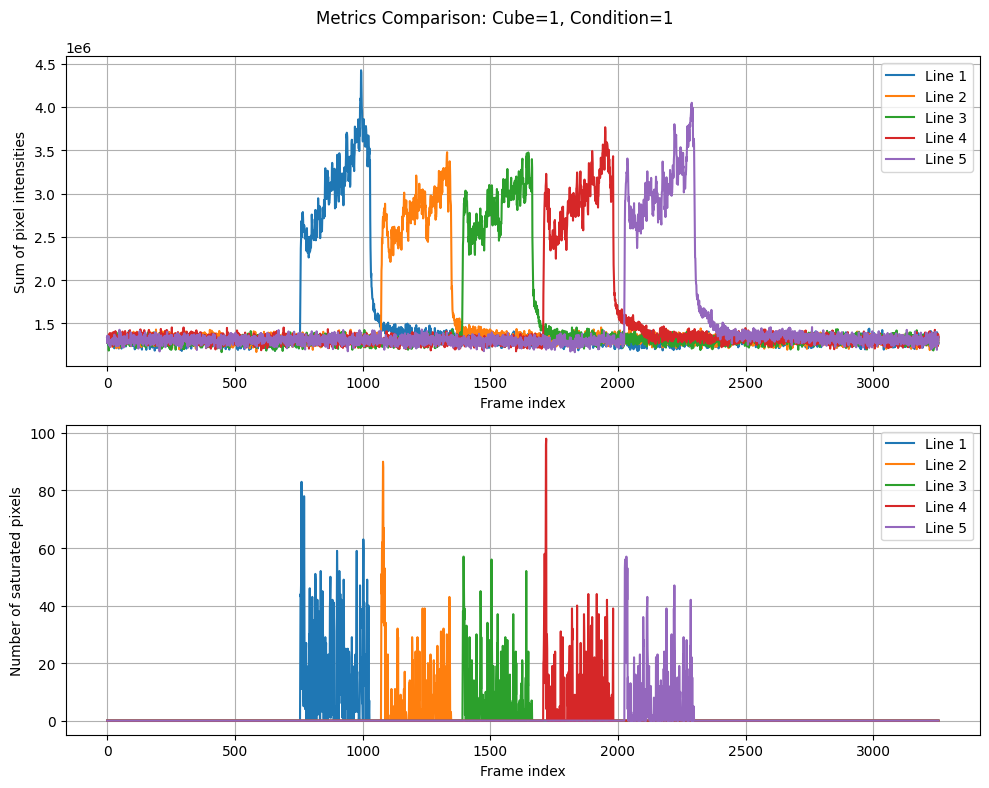

In [7]:
# Compare specific metrics across lines
plot_metric_comparison(results, cube=1, condition=1, 
                      metrics_to_compare=['intensities', 'saturated_pixels'])

In [8]:
# Access metrics for a specific video
cube, condition, line = 1, 1, 1
video_metrics = results[cube][condition][line]

# Look at specific metrics
intensities = video_metrics['intensities']
saturated_counts = video_metrics['saturated_pixels']
max_values = video_metrics['max_values']

In [9]:
max(max_values)

np.int64(4095)